# Distilling the Knowledge in a Neural Network
### Reference
1. [paper](https://arxiv.org/abs/1503.02531)
2. [keras](https://keras.io/examples/vision/knowledge_distillation/)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend

# Teacher model

In [2]:
def building_block(filter, args, stage, block):
  def resblock(X_in):
    x = layers.BatchNormalization()(X_in)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filter,
                      kernel_size=(3, 3),
                      strides=(1, 1) if stage == 0 or block > 0 else (2, 2),
                      padding='same',
                      kernel_initializer=args.init,
                      kernel_regularizer=args.reg)(x)

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filter,
                      kernel_size=(3, 3),
                      strides=(1, 1),
                      padding='same',
                      kernel_initializer=args.init,
                      kernel_regularizer=args.reg)(x)

    if stage == 0 or block > 0:
      x_out = layers.Add()([x, X_in])
    else:
      id = layers.Conv2D(filters=filter,
                        kernel_size=(1, 1),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=args.init,
                        kernel_regularizer=args.reg)(X_in)
      x_out = layers.Add()([x, id])
    return x_out
  return resblock

In [3]:
def build_model(args):
  X_in = layers.Input(shape=args.input_shape)
  x = layers.Conv2D(filters=args.filters[0],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(X_in)
  for stage, filter in enumerate(args.filters):
    for block in range(args.blocks):
      x = building_block(filter, args, stage, block)(x)
      print(f'{stage+2}-{block+1}block {x.shape}')

  x = layers.GlobalAveragePooling2D()(x)
  x_out = layers.Dense(units=args.num_class)(x)
  return models.Model(inputs=X_in, outputs=x_out)

In [4]:
class Config:
  lr = 1e-2
  batch_size = 128
  epochs = 14
  weight_decay = 1e-4
  decay_step = 2
  input_shape = (28, 28, 1)
  filters = [16, 32, 64]
  blocks = 3
  num_class = 10
  opt = optimizers.Adam(learning_rate=lr)
  loss = losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = metrics.SparseCategoricalAccuracy()
  init = initializers.HeNormal()
  reg = regularizers.L2(l2=weight_decay)

In [5]:
big_model = build_model(Config)

2-1block (None, 28, 28, 16)
2-2block (None, 28, 28, 16)
2-3block (None, 28, 28, 16)
3-1block (None, 14, 14, 32)
3-2block (None, 14, 14, 32)
3-3block (None, 14, 14, 32)
4-1block (None, 7, 7, 64)
4-2block (None, 7, 7, 64)
4-3block (None, 7, 7, 64)


In [6]:
def input_pipeline(feature, label, batch_size, validation_split:float=0.1, pad:int=4):
  try:
    N, H, W, C = feature.shape
  except:
    feature = tf.expand_dims(feature, axis=-1)
    N, H, W, C = feature.shape

  ds = tf.data.Dataset.from_tensor_slices((feature, label))
  ds = ds.map(lambda x, y: (tf.divide(tf.cast(x, tf.float32), 255.), y))
  ds = ds.map(lambda x, y: (tf.divide(tf.subtract(x, tf.math.reduce_mean(x)), tf.math.reduce_std(x)), y))
  ds = ds.shuffle(1000)
  ds = ds.cache()

  assert 0 <= validation_split < 1
  if validation_split:
    val_len = int(N * validation_split)
    val_ds = ds.take(val_len)
    train_ds = ds.skip(val_len)

  crop = train_ds.map(lambda x, y: (tf.image.resize_with_pad(x, H+pad*2, W+pad*2), y))
  crop = crop.map(lambda x, y: (tf.image.random_crop(x, (H, W, C)), y))
  train_ds = train_ds.concatenate(crop)
  train_ds = train_ds.shuffle(1000)
  train_ds = train_ds.cache()
  train_ds = train_ds.batch(batch_size=batch_size)
  val_ds = val_ds.batch(batch_size=batch_size)
  val_ds = val_ds.prefetch(1)
  train_ds = train_ds.prefetch(1)
  print('Trian mini batch: ', train_ds.cardinality().numpy(), '           val mini batch: ', val_ds.cardinality().numpy())
  return train_ds, val_ds

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
train_ds, val_ds = input_pipeline(x_train, y_train, Config.batch_size)

Trian mini batch:  844            val mini batch:  47


In [9]:
class DecoupleHelper(callbacks.Callback):
  def __init__(self, init_lr, decay_steps, regularizer:bool=None):
    self.init_lr = init_lr
    self.regularizer = regularizer
    self.weight_decay = None
    if self.regularizer:
      self.weight_decay = self.regularizer.l2
    self.decay_steps = decay_steps
    self.best_acc = None
    self.best_weights = None
    self.best_epoch = None
    self.iter_counter = 0

  def on_train_begin(self, logs=None):
    if not hasattr(self.model.optimizer.lr, 'lr'):
      backend.set_value(self.model.optimizer.lr, self.init_lr)

  def on_epoch_end(self, epoch, logs=None):
    next_lr = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.init_lr,
                                                       first_decay_steps=self.decay_steps)(epoch+1).numpy()
    backend.set_value(self.model.optimizer.lr, next_lr)
    logs.update({'next_lr': next_lr})
    if self.regularizer:
      next_wd = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.weight_decay,
                                                         first_decay_steps=self.decay_steps)(epoch+1).numpy()
      self.regularizer.lr = next_wd
      logs.update({'next_wd': next_wd})
    curr_acc = logs.get('val_sparse_categorical_accuracy')
    if self.best_acc is None:
      self.best_acc = curr_acc
    
    if self.best_acc < curr_acc:
      self.best_acc = curr_acc
      self.best_weights = self.model.get_weights()
      self.best_epoch = epoch
      logs.update({'WEIGHT UPDATED': True})

  def on_train_end(self, logs=None):
    if self.best_weights:
      self.model.set_weights(self.best_weights)
      print('Training end')

## Train teacher model

In [10]:
big_model.compile(optimizer=Config.opt,
                  loss=Config.loss,
                  metrics=Config.metric)

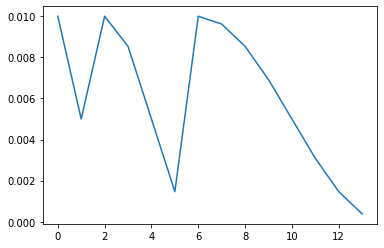

In [11]:
import numpy as np
import matplotlib.pyplot as plt
log = []
for i in range(14):
  lr = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-2, first_decay_steps=2)(i).numpy()
  log.append(lr)

plt.plot(log)

In [12]:
big_model.fit(x=train_ds,
              validation_data=val_ds,
              epochs=Config.epochs,
              callbacks=[DecoupleHelper(init_lr=Config.lr,
                                    decay_steps=Config.decay_step,
                                    regularizer=Config.reg)])

Epoch 1/14
844/844 [==============================] - 73s 70ms/step - loss: 0.9589 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.8723 - next_lr: 0.0050 - next_wd: 5.0000e-05
Epoch 2/14
844/844 [==============================] - 56s 67ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.9467 - next_lr: 0.0100 - next_wd: 1.0000e-04 - WEIGHT UPDATED: 1.0000
Epoch 3/14
844/844 [==============================] - 56s 67ms/step - loss: 0.2035 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.2362 - val_sparse_categorical_accuracy: 0.9655 - next_lr: 0.0085 - next_wd: 8.5355e-05 - WEIGHT UPDATED: 1.0000
Epoch 4/14
844/844 [==============================] - 56s 66ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.3363 - val_sparse_categorical_accuracy: 0.9227 - next_lr: 0.0050 - next_wd: 5.0000e-05
Epoch 5/14
844/844 [==============================] - 56s 67ms

Text(0.5, 1.0, 'Teacher Model')

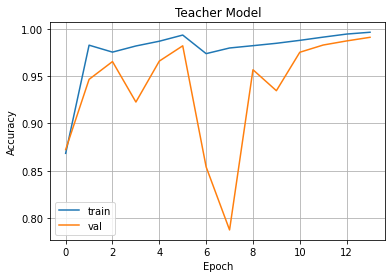

In [13]:
plt.plot(big_model.history.history.get('sparse_categorical_accuracy'), label='train')
plt.plot(big_model.history.history.get('val_sparse_categorical_accuracy'), label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Teacher Model')

# Student model

In [14]:
small_model = models.Sequential()
small_model.add(layers.Input(shape=Config.input_shape))
small_model.add(layers.Conv2D(filters=16,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.Activation(tf.nn.relu))
small_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_model.add(layers.Conv2D(filters=32,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.Activation(tf.nn.relu))
small_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_model.add(layers.Conv2D(filters=64,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.GlobalAveragePooling2D())
small_model.add(layers.Dense(units=Config.num_class))

# Distiller class

In [15]:
class Distiller(models.Model):
  def __init__(self, teacher, student):
    super(Distiller, self).__init__()
    self.teacher = teacher
    self.student = student
    self.t = None
    self.alpha = None
    self.student_objective = None
    self.distiller_objective = None

  def compile(self, optimizer, metrics, distiller_objective, student_objective, t, alpha):
    super(Distiller, self).compile(optimizer=optimizer, metrics=metrics,)
    self.distiller_objective = distiller_objective
    self.student_objective = student_objective
    self.t = t
    self.alpha = alpha

  def train_step(self, data):
    x, y = data
    teacher_pred = self.teacher(x, training=False)   # (batch, num_class)
    with tf.GradientTape() as tape:
      student_pred = self.student(x, training=True)   # (batch, num_class)
      distiller_loss = self.distiller_objective(tf.nn.softmax(teacher_pred / self.t, axis=1),
                                                tf.nn.softmax(student_pred / self.t, axis=1))
      student_loss = self.student_objective(y, teacher_pred)
      loss = (1 - self.alpha) * distiller_loss + self.alpha * student_loss

    trainable = self.student.trainable_weights
    grads = tape.gradient(loss, trainable)
    self.optimizer.apply_gradients(zip(grads, trainable))
    self.compiled_metrics.update_state(y, student_pred)

    results = {m.name: m.result() for m in self.metrics}
    print(results)
    results.update({'student_loss': student_loss,
                    'distiller_loss': distiller_loss})
    return results

  def test_step(self, data):
    x, y = data
    val_pred = self.student(x, training=False)
    val_loss = self.student_objective(y, val_pred)

    self.compiled_metrics.update_state(y, val_pred)
    results = {m.name: m.result() for m in self.metrics}
    results.update({'val_student_loss': val_loss})
    return results

In [16]:
x_train = x_train/255.
x_train = (x_train - tf.math.reduce_mean(x_train)) / tf.math.reduce_std(x_train)

In [17]:
y_train = tf.expand_dims(y_train, axis=1)
x_train = tf.expand_dims(x_train, axis=3)

In [18]:
distiller = Distiller(teacher=big_model, student=small_model)
distiller.compile(
    optimizer=optimizers.Adam(learning_rate=Config.lr),
    metrics=metrics.SparseCategoricalAccuracy(),
    distiller_objective=losses.KLDivergence(),
    student_objective=losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha=0.1,
    t=10
    )

In [19]:
distiller.fit(x=x_train,
              y=y_train,
              epochs=5,
              validation_split=0.2,
              callbacks=[DecoupleHelper(init_lr=Config.lr,
                                        decay_steps=Config.decay_step,
                                        regularizer=Config.reg)])

Epoch 1/5
{'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>}
{'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>}
1500/1500 [==============================] - 21s 13ms/step - sparse_categorical_accuracy: 0.7629 - student_loss: 0.0522 - distiller_loss: 0.0625 - val_sparse_categorical_accuracy: 0.8802 - val_val_student_loss: 0.2230 - next_lr: 0.0050 - next_wd: 5.0000e-05
Epoch 2/5
1500/1500 [==============================] - 18s 12ms/step - sparse_categorical_accuracy: 0.8907 - student_loss: 0.0521 - distiller_loss: 0.0379 - val_sparse_categorical_accuracy: 0.8964 - val_val_student_loss: 0.1522 - next_lr: 0.0100 - next_wd: 1.0000e-04 - WEIGHT UPDATED: 1.0000
Epoch 3/5
1500/1500 [==============================] - 16s 11ms/step - sparse_categorical_accuracy: 0.8975 - student_loss: 0.0522 - distiller_loss: 0.0367 - val_sparse_categorical_accuracy: 0.9099 - val_val_student_loss: 0.1619 - next_lr: 0.0085 - next_wd: 8.5355e-05 - WEIGHT 

Text(0.5, 1.0, 'Distilled model')

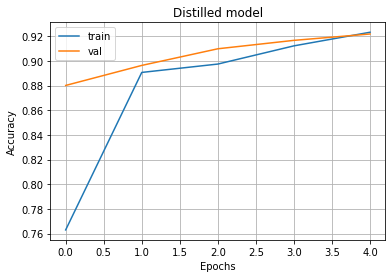

In [20]:
plt.plot(distiller.history.history.get('sparse_categorical_accuracy'), label='train')
plt.plot(distiller.history.history.get('val_sparse_categorical_accuracy'), label='val')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Distilled model')

In [21]:
x_test = x_test/255.
x_test = (x_test - tf.math.reduce_mean(x_test)) / tf.math.reduce_std(x_test)

In [22]:
big_model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 19ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9843


[0.0882778987288475, 0.9843000173568726]

In [23]:
distiller.evaluate(x_test, y_test)

313/313 [==============================] - 3s 7ms/step - sparse_categorical_accuracy: 0.9161 - val_student_loss: 0.2839


[0.916100025177002, 0.13780920207500458]